In [2]:
from nilearn import plotting, datasets, surface  
import matplotlib.pyplot as plt
import matplotlib.colors as colors	
import numpy as np 
import SimpleITK as sitk
import pandas as pd
from scipy import ndimage as ndi

In [3]:
def resample_sitk(input_image, reference_image):
    """
    Resamples a SimpleITK image to match the spacing, 
    size, and orientation of a reference image.
    
    Parameters
    ----------
    input_image  : SimpleITK.Image
        The input image to be resampled.
    reference_image : SimpleITK.Image
        The reference image whose spacing, size, 
        and orientation will be used for resampling.

    Returns
    ---------    
    resampled_image: simpleITK image object 
    
    """
    # Create an identity transform
    identity_transform = sitk.Transform()

    # Define the interpolator to use
    interpolator = sitk.sitkLinear

    # Define the default pixel value for points outside the input image
    defaultPixelValue = 0

    # Define the output pixel type
    outputPixelType = sitk.sitkFloat32

    # Resample the input image
    resampled_image = sitk.Resample(input_image, reference_image, identity_transform, interpolator, defaultPixelValue,
                                    outputPixelType)
    return resampled_image


In [34]:
def intensity_regions_bar_chart(regions, intensity1, intensity2, intensity3,  hemisphere=None, title=None):
    """
        Creates a bar chart using the brain regions in the x-axis and the signal intensity in the y-axis.

        Parameters
        ----------
        regions : list of brain regions
        intensity: list of signal intensity for every region in regions.
        title: title of the graph

    """
    # set width of bars 
    barWidth = 0.25
    
    # Set position of bar on X axis 
    r1 = np.arange(len(intensity1)) 
    r2 = [x + barWidth for x in r1] 
    r3 = [x + barWidth for x in r2]

    intensity_pet = [intensity1, intensity2, intensity3]

    plt.bar(r1, intensity_pet[0], color="#ffd343", width= 0.3, label='CEUNIM subject')
    plt.bar(r2, intensity_pet[1], color='#ff7442', width= 0.3, label='Atlas FDG-PET')
    plt.bar(r3, intensity_pet[2], color='#ccff42', width= 0.3, label='Control subject')

    plt.xlabel("Regions", size=16)
    plt.ylabel("Intensity", size=16)
    plt.xticks([r + barWidth for r in range(len(regions))], regions)
    
    if title != None: plt.title(title, size=16)
    else:
        plt.title("Gráfico por intensidades", size=16)
    legend = plt.legend(fontsize='small')
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 0.1))

    plt.subplots_adjust(right=0.80)
    


In [4]:
atlas_Hammers = "Hammers_mith-n30r95-MaxProbMap-gm-MNI152-SPM12.nii.gz"
sitk_atlas_hammers = sitk.ReadImage(atlas_Hammers)

# cambios cerebro control 
cambios_cerebro_control = "Control/synthetic_image_changes.nii.gz"

# read T1 control normalizada
path_T1_control = "Control/T1_Norm_MNI_152_ANTWarped.nii.gz"
sitk_T1_control = sitk.ReadImage(path_T1_control)

# read T1 CEUNIM normal
path_T1_CEUNIM = "ANTs/T1_Norm_MNI_152_ANTWarped.nii.gz"
sitk_T1_CEUNIM = sitk.ReadImage(path_T1_CEUNIM)

# resample Control T1 to Hammers
sitk_T1_control = resample_sitk(sitk_T1_control, sitk_atlas_hammers)
img_T1_control = sitk.GetArrayFromImage(sitk_T1_control)
control_T1_nii = "T1_resampleado_only_brain_control.nii.gz"
sitk.WriteImage(sitk_T1_control, control_T1_nii)

# cambios cerebro CEUNIM
cambios_cerebro_CEUNIM = "Synthetic_Image/synthetic_image_changes.nii.gz"

# resample Control CEUNIM to Hammers
sitk_T1_CEUNIM = resample_sitk(sitk_T1_CEUNIM, sitk_atlas_hammers)
img_T1_CEUNIM = sitk.GetArrayFromImage(sitk_T1_CEUNIM)
CEUNIM_T1_nii = "T1_resampleado_only_brain_ceunim.nii.gz"
sitk.WriteImage(sitk_T1_CEUNIM, CEUNIM_T1_nii)

0.9

0.9

In [5]:
# read dfs
CEUNIM_intensity = pd.read_csv("CSV/subject_CEUNIM_intensity.csv")
MNI152_intensity = pd.read_csv("CSV/MNI152_intensity.csv")
control_intensity = pd.read_csv("CSV/subject_control_intensity.csv")
df_cambios_CEUNIM = pd.read_csv("CSV/Intensity_image_changes.csv")

In [6]:
 # Sort the dataframe for change column in descendent order 
df_cambios_CEUNIM_sorted = df_cambios_CEUNIM.sort_values("cambio")

# Top values in the Dataframe 
top = df_cambios_CEUNIM_sorted.head(4)

top

,Unnamed: 0,n_label,cambio,structure,hemisphere
32,32,32,-51.590893,PL-angular-gyrus,L
81,81,84,-48.810290,PL-supramarginal-gyrus,L
33,33,33,-47.127886,PL-angular-gyrus,R
61,61,62,-43.491044,PL-superior-parietal-gyrus,L


In [7]:
labels_top = list(top["n_label"])


In [8]:
top_MNI = pd.DataFrame()
top_control = pd.DataFrame()
top_CEUNIM = pd.DataFrame()

for label in labels_top:

    #MNI 
    row_MNI = MNI152_intensity.loc[MNI152_intensity['n_label'] == label]
    top_MNI = pd.concat([top_MNI, row_MNI], ignore_index=True)

    #control
    row_control = control_intensity.loc[control_intensity['n_label'] == label]
    top_control = pd.concat([top_control, row_control], ignore_index=True)

    # CEUNIM 
    row_CEUNIM = CEUNIM_intensity.loc[CEUNIM_intensity['n_label'] == label]
    top_CEUNIM = pd.concat([top_CEUNIM, row_CEUNIM], ignore_index=True)

regions = top_CEUNIM["structure"] + "-" + top_CEUNIM["hemisphere"]

regions

0              PL-angular-gyrus-L
1        PL-supramarginal-gyrus-L
2              PL-angular-gyrus-R
3    PL-superior-parietal-gyrus-L
dtype: object

In [11]:
regions_label = []
for name in regions: 
    region_label = ""
    aux = name.split("-")[1:]
    
    if aux[-1] == "L": 
        region_label = "Left" + "\n"
    elif aux[-1] == "R": 
        region_label = "Right" + "\n"
    
    aux2 = "\n".join(aux[0:len(aux) - 1])
    region_label = region_label + aux2
    regions_label.append(region_label)

    


Left

Left

Left



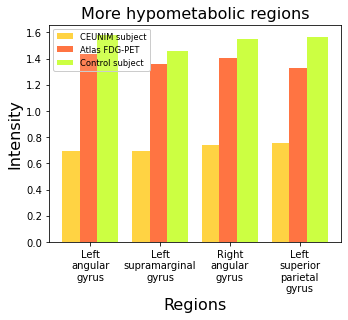

In [40]:
intensity_regions_bar_chart(regions_label, top_CEUNIM["normalization"],  top_MNI["normalization"], top_control["normalization"], title="More hypometabolic regions")
plt.savefig("intensity.png")

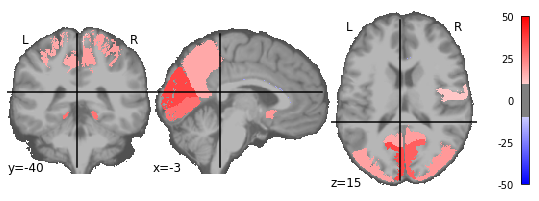

In [41]:
plotting.plot_stat_map(cambios_cerebro_control, bg_img=control_T1_nii, 
                       annotate=True, 
                       cmap="bwr",black_bg=False, cut_coords=(-3,-40,15), display_mode="ortho", 
                       threshold = 10, vmax=50)
plt.savefig("brain_control.svg")

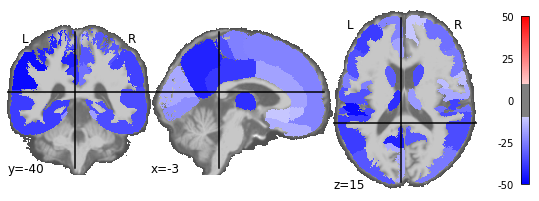

In [42]:
plotting.plot_stat_map(cambios_cerebro_CEUNIM, bg_img=CEUNIM_T1_nii, 
                       annotate=True, 
                       cmap="bwr",black_bg=False, cut_coords=(-3,-40,15), display_mode="ortho", 
                       threshold = 10, vmax=50)
plt.savefig("brain_ceunim.svg")